In [49]:
import pandas as pd
import numpy as np

import sys
import os

# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import your module
from utils import factor_model_solution, factor_goodness_of_fit_test

*This notebook does factor analysis on k = 2 pathways, trying to identify the 2 pathways in which DICER1 and GART participate in respectively.*
___
# $k = 2$ factors | GART & DICER1 pathways

## Loading and preparing data

See the `k1_[GENE]_initial_analysis.ipynb` notebooks for more intermediate steps than this notebook provides.

In [50]:
df_gene_effect = pd.read_csv("preprocessed_data/20Q4v2_Achilles_gene_effect.csv")
df_correlations = {
    "DICER1": pd.read_csv("preprocessed_data/corr_DICER1_preprocessed.csv", delimiter=";"),
    "GART": pd.read_csv("preprocessed_data/corr_GART_preprocessed.csv", delimiter=";")
}


In [ ]:
# Number of genes to include from each corr file taking top X // 2 and bottom X // 2.
# Note that the same gene may be selected in both corr files. (But will only appear once in the final selected_genes list.)
number_of_genes = 40

assert number_of_genes % 2 == 0, "number_of_genes should be an even number."

selected_columns = pd.concat([df_correlations["DICER1"]["gene_evaluated"][:number_of_genes // 2],
                              df_correlations["DICER1"]["gene_evaluated"][-number_of_genes // 2:],
                              df_correlations["GART"]["gene_evaluated"][:number_of_genes // 2],
                              df_correlations["GART"]["gene_evaluated"][-number_of_genes // 2:]]).to_list()
selected_columns = set(selected_columns)

# number_of_genes multiplied by how many corr files we have.
number_of_duplicates = (number_of_genes * len(df_correlations)) - len(selected_columns) 
if number_of_duplicates > 0:
    print(f"WARNING: {number_of_duplicates} duplicates were removed.")

# Extract gene names according to the format of gene_effect dataset.
selected_columns_gene_effect_format = [column for column in df_gene_effect.columns if column.split(" ")[0] in selected_columns]

# Rough automatic check for whether we found all corresponding columns in gene_effect dataset that we've selected.
if not len(selected_columns) == len(selected_columns_gene_effect_format):
    print(f"WARNING: {len(selected_columns) - len(selected_columns_gene_effect_format)} column were not found in the database.")

# Extract columns from gene_effect dataset.
X = df_gene_effect[selected_columns_gene_effect_format].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
num_dropped_rows = df_gene_effect.shape[0] - X.shape[0]
if num_dropped_rows > 0:
    print(f"WARNING: {num_dropped_rows} rows contained at least 1 NA and was dropped.")
X.shape

(778, 78)

In [52]:
num_random_cols = 20
add_random = False

if add_random:
    X = np.hstack([X] + [np.random.random(size=X.shape[0]).reshape(-1, 1) for _ in range(num_random_cols)])

X.shape

(778, 78)

## Data Analysis

In [53]:
_, lambda_hat = factor_model_solution(X, k = 2)
lambda_hat

array([[ 0.03541632, -0.01083866],
       [-0.80913396,  0.00511538],
       [-0.07021311,  0.42964709],
       [-0.07602636,  0.40475621],
       [-0.8652533 ,  0.00117935],
       [ 0.06009843,  0.16919403],
       [ 0.00329713, -0.10605155],
       [-0.6882036 ,  0.01280755],
       [ 0.03416358,  0.06358596],
       [ 0.01746349, -0.07831078],
       [ 0.14642018,  0.03931324],
       [ 0.12820419,  0.29784039],
       [-0.6713473 , -0.06681368],
       [-0.72262949,  0.02265679],
       [ 0.00103836,  0.80476879],
       [ 0.11529548,  0.35089863],
       [ 0.05727633,  0.26796681],
       [ 0.00875446,  0.40234215],
       [-0.1121641 ,  0.25441507],
       [ 0.04171461, -0.15431767],
       [-0.72433862, -0.03406309],
       [-0.85956552, -0.02336988],
       [-0.70412493, -0.03602457],
       [ 0.06640027, -0.13086003],
       [ 0.16726291,  0.20181205],
       [ 0.03274647,  0.12255635],
       [-0.09076393,  0.00622548],
       [-0.04727988, -0.12413862],
       [ 0.14228673,

In [54]:
loadings = lambda_hat.T # Extract loadings as a list

# Extract gene names (everything before the space)
genes = [column.split(" ")[0] for column in selected_columns_gene_effect_format] 

if add_random:
    genes = genes + [str(i) + " random col" for i in range(num_random_cols)]

# Create a DataFrame from genes and values
df_values = pd.DataFrame({
    'gene_evaluated': genes,
    'loadings0': loadings[0],
    'loadings1': loadings[1]
})

# Merge with df_correlations on 'gene'
merged_df = (df_values
             .merge(df_correlations["DICER1"][['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')
             .rename(columns={"is_on_pathway": "is_on_pathway_DICER1"})
             .merge(df_correlations["GART"][['gene_evaluated', 'is_on_pathway']], on='gene_evaluated', how='left')
             .rename(columns={"is_on_pathway": "is_on_pathway_GART"})
             )

In [55]:
# Allow pandas to display wider tables before linebreaking.
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Sorted w.r.t. first factor:

In [56]:
print(merged_df.sort_values("loadings0", ascending=False))

   gene_evaluated  loadings0  loadings1  is_on_pathway_DICER1  is_on_pathway_GART
65       SLC25A28   0.270034  -0.067985                   0.0                 0.0
52           POP4   0.208283   0.127792                   0.0                 NaN
24          HYOU1   0.167263   0.201812                   0.0                 0.0
10         CEP135   0.146420   0.039313                   NaN                 0.0
47           PCNT   0.143784  -0.047177                   NaN                 0.0
..            ...        ...        ...                   ...                 ...
35         MTHFD1  -0.833340   0.044730                   NaN                 1.0
53           PPAT  -0.849688  -0.059014                   NaN                 1.0
21           GART  -0.859566  -0.023370                   NaN                 1.0
4            ATIC  -0.865253   0.001179                   NaN                 1.0
45          PAICS  -0.893742   0.006011                   NaN                 1.0

[78 rows x 5 co

Correctly finds the GART pathway. 

Sorted w.r.t. second factor:

In [57]:
print(merged_df.sort_values("loadings1", ascending=False))

   gene_evaluated  loadings0  loadings1  is_on_pathway_DICER1  is_on_pathway_GART
14         DICER1   0.001038   0.804769                   1.0                 0.0
76           XPO5  -0.062134   0.578577                   1.0                 0.0
2            AGO2  -0.070213   0.429647                   1.0                 NaN
3         ANKRD52  -0.076026   0.404756                   1.0                 0.0
17         DROSHA   0.008754   0.402342                   1.0                 0.0
..            ...        ...        ...                   ...                 ...
42         ORMDL2  -0.006803  -0.149891                   0.0                 NaN
19        FAM151B   0.041715  -0.154318                   NaN                 0.0
57           PTEN  -0.100723  -0.180314                   0.0                 0.0
40         NKX6-3   0.110771  -0.222368                   0.0                 NaN
29         MAP4K4  -0.111015  -0.242544                   0.0                 NaN

[78 rows x 5 co

Correctly finds the DICER1 pathway. (Notice somewhat significant drop-off from DROSHA to HYOU1)

## Goodness of Fit

In [58]:
# print(factor_goodness_of_fit_test(X, k = 2))

# for i in range(1, X.shape[1]):
#     pvalue = factor_goodness_of_fit_test(X, k = i)
#     if pvalue >= 0.05:
#         print("Found sufficient factors:")
#         print("FAC| PVAL")
#         print(f" {i} | {pvalue.round(4)}")
#         print(f"({i - 1} | {factor_goodness_of_fit_test(X, k = i - 1).round(4)})")
#         break

## Plotting

Text(0, 0.5, '2nd Factor')

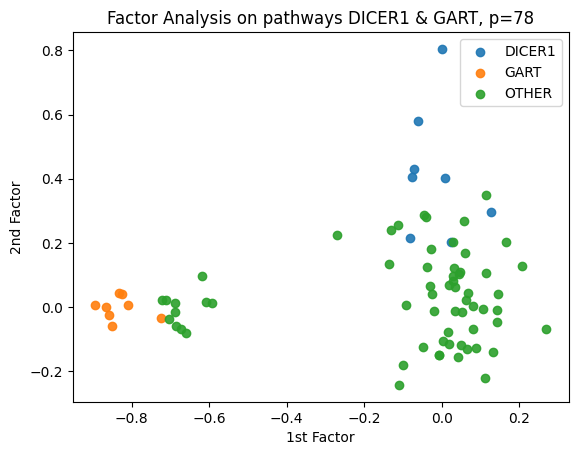

In [59]:
import matplotlib.pyplot as plt

colors = []
for d, g in zip(merged_df['is_on_pathway_DICER1'], merged_df['is_on_pathway_GART']):
    if d == 1:
        colors.append("DICER1")
        continue

    if g == 1:
        colors.append("GART")
        continue

    colors.append("OTHER")

merged_df['category'] = colors

for label in ["DICER1", "GART", "OTHER"]:
    subset = merged_df[merged_df['category'] == label]
    plt.scatter(subset['loadings0'], subset['loadings1'], label=label, alpha=0.9)
plt.title("Factor Analysis on pathways DICER1 & GART, p=" + str(len(merged_df)))
plt.legend()
plt.xlabel("1st Factor")
plt.ylabel("2nd Factor")

In [60]:
from utils import varimax

rotated_lambda = varimax(np.array([merged_df['loadings0'], merged_df['loadings1']]).T, verbose=True)
rotated_df = merged_df.copy()
rotated_df['loadings0'] = rotated_lambda[:,0]
rotated_df['loadings1'] = rotated_lambda[:,1]
rotated_df.head()

cycle:	1	theta:	0.0	pair:	(0, 1)	objective:	26.976372001252443
Phi has converged; Algorithm ending early.


,gene_evaluated,loadings0,loadings1,is_on_pathway_DICER1,is_on_pathway_GART,category
0,ACD,0.035416,-0.010839,NaN,0.0,OTHER
1,ADSL,-0.809134,0.005115,NaN,1.0,GART
2,AGO2,-0.070213,0.429647,1.0,NaN,DICER1
3,ANKRD52,-0.076026,0.404756,1.0,0.0,DICER1
4,ATIC,-0.865253,0.001179,NaN,1.0,GART


Text(0, 0.5, '2nd Factor')

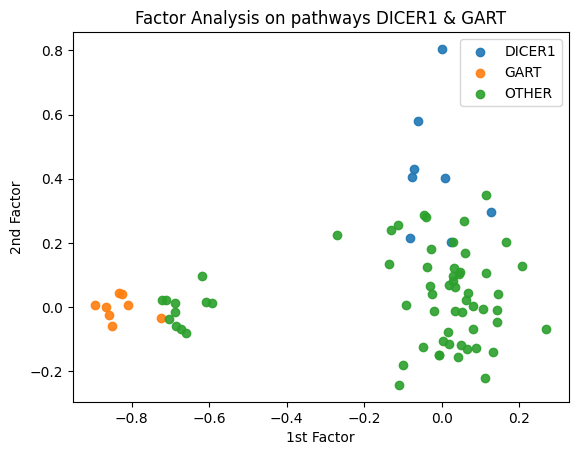

In [61]:
for label in ["DICER1", "GART", "OTHER"]:
    subset = rotated_df[rotated_df['category'] == label]
    plt.scatter(subset['loadings0'], subset['loadings1'], label=label, alpha=0.9)

plt.title("Factor Analysis on pathways DICER1 & GART")
plt.legend()
plt.xlabel("1st Factor")
plt.ylabel("2nd Factor")